In [1]:
import numpy as np
import astropy.units as u
import astropy.table
import astropy.io.fits
import plasmapy
import pathlib
import matplotlib.pyplot as plt

from astropy.coordinates import SkyCoord
from astropy.convolution import convolve, Gaussian1DKernel
import ndcube
from ndcube.extra_coords import QuantityTableCoordinate
import fiasco
import aiapy.response
from sunpy.coordinates import get_earth, Helioprojective

from fiasco.io import Parser
from fiasco.util import parse_ion_name
from synthesizAR.instruments import InstrumentDEM

from mocksipipeline.physics.spectral import get_spectral_tables
from mocksipipeline.detector.response import SpectrogramChannel, convolve_with_response

# Updated 1D Spectral Predictions

Using new effective area and inclusion of 2nd order contribution, model 1D AR spectrum.

In [2]:
def dem_table_to_ndcube(dem_table):
    temperature = dem_table['temperature_bin_center']
    em = dem_table['dem']*np.gradient(temperature, edge_order=2)
    tab_coord = QuantityTableCoordinate(temperature,
                                        names='temperature',
                                        physical_types='phys.temperature')
    return ndcube.NDCube(em, wcs=tab_coord.wcs, meta=dem_table.meta)

In [3]:
def compute_total_flux(dem, spec_table, channels, location, ):
    intensity = InstrumentDEM.calculate_intensity(dem, spec_table, {})
    wcs = channels[0].get_wcs(location.observer)
    pix_grid, _, _ = wcs.world_to_pixel(location, channels[0].wavelength)
    flux_total = np.zeros(pix_grid.shape)
    for chan in channels:
        flux = convolve_with_response(intensity, chan, electrons=False, include_gain=False)
        _pix_grid, _, _ = chan.get_wcs(location.observer).world_to_pixel(location, chan.wavelength)
        flux_total += np.interp(pix_grid, _pix_grid, flux.data)
    return ndcube.NDCube(flux_total, flux.wcs, unit=flux.unit)

In [4]:
def degrade_spectra(spec, resolution, chan):
    std = resolution / chan.spectral_order / (2*np.sqrt(2*np.log(2)))  # FWHM is 0.5 so convert to sigma using W = 2\sqrt{2\ln2}\sigma
    std_eff = (std / chan.spectral_resolution).to_value('pix')  # Scale sigma by bin width
    kernel = Gaussian1DKernel(std_eff)
    data_smooth = convolve(spec.data, kernel)
    return ndcube.NDCube(data_smooth, wcs=spec.wcs, meta=spec.meta, unit=spec.unit)

In [5]:
dem_ar = dem_table_to_ndcube(Parser('active_region.dem', ascii_dbase_root='/Users/wtbarnes/ssw/packages/chianti/dbase/').parse())

In [6]:
dem_flare = dem_table_to_ndcube(Parser('flare_ext.dem', ascii_dbase_root='/Users/wtbarnes/ssw/packages/chianti/dbase/').parse())

In [7]:
spec_tables = get_spectral_tables()

In [8]:
line_list = astropy.table.QTable.read('../data/moxsi-line-list.asdf')

In [9]:
earth_observer = get_earth(time='2020-01-01 12:00:00')
flare_loc = SkyCoord(Tx=0*u.arcsec, Ty=0*u.arcsec,
                     frame=Helioprojective(obstime=earth_observer.obstime, observer=earth_observer))
roll_angle = -90 * u.deg
dispersion_angle = 0*u.deg

In [10]:
chan_1 = SpectrogramChannel(1)
chan_2 = SpectrogramChannel(2)
chan_3 = SpectrogramChannel(3)

In [12]:
flux_tot = compute_total_flux(dem_ar,
                              spec_tables['sun_coronal_1992_feldman_ext_all'],
                              [chan_1, chan_2, chan_3],
                              flare_loc)
blur = 40 * u.arcsec * chan_1.spectral_resolution / chan_1.resolution[0]
flux_tot = degrade_spectra(flux_tot, blur, chan_1)

In [13]:
pix_grid_1,_,_ = chan_1.get_wcs(flare_loc.observer).world_to_pixel(flare_loc, chan_1.wavelength)
pix_grid_2,_,_ = chan_2.get_wcs(flare_loc.observer).world_to_pixel(flare_loc, chan_2.wavelength)
pix_grid_3,_,_ = chan_3.get_wcs(flare_loc.observer).world_to_pixel(flare_loc, chan_3.wavelength)

In [14]:
flux_1 = compute_total_flux(dem_ar, spec_tables['sun_coronal_1992_feldman_ext_all'], [chan_1,], flare_loc)
flux_1 = degrade_spectra(flux_1, blur, chan_1)
flux_2 = compute_total_flux(dem_ar, spec_tables['sun_coronal_1992_feldman_ext_all'], [chan_2,], flare_loc)
flux_2 = degrade_spectra(flux_2, blur, chan_2)
flux_3 = compute_total_flux(dem_ar, spec_tables['sun_coronal_1992_feldman_ext_all'], [chan_3,], flare_loc)
flux_3 = degrade_spectra(flux_3, blur, chan_3)

In [20]:
ar_line_labels = line_list[line_list['intensity_scaled (coronal)_active_region']>0.1]
ar_line_labels = ar_line_labels[['ion name', 'wavelength', 'ion id']]
#ar_line_labels = ar_line_labels[np.logical_or(ar_line_labels['ion name'] == 'O VIII', ar_line_labels['ion name'] == 'O VII')]
#ar_line_labels = ar_line_labels[ar_line_labels['wavelength'] > 20*u.angstrom]
#is_iron = ['Si' in i for i in ar_line_labels['ion name']]
#ar_line_labels = ar_line_labels[is_iron]

In [21]:
ar_line_labels

ion name,wavelength,ion id
,Angstrom,
str9,float64,str5
C V,40.267398834228516,c_5
C V,41.471500396728516,c_5
C VI,33.739601135253906,c_6
C VI,33.73419952392578,c_6
O VII,21.601499557495117,o_7
O VII,21.803600311279297,o_7
O VII,22.097700119018555,o_7
O VIII,18.97249984741211,o_8


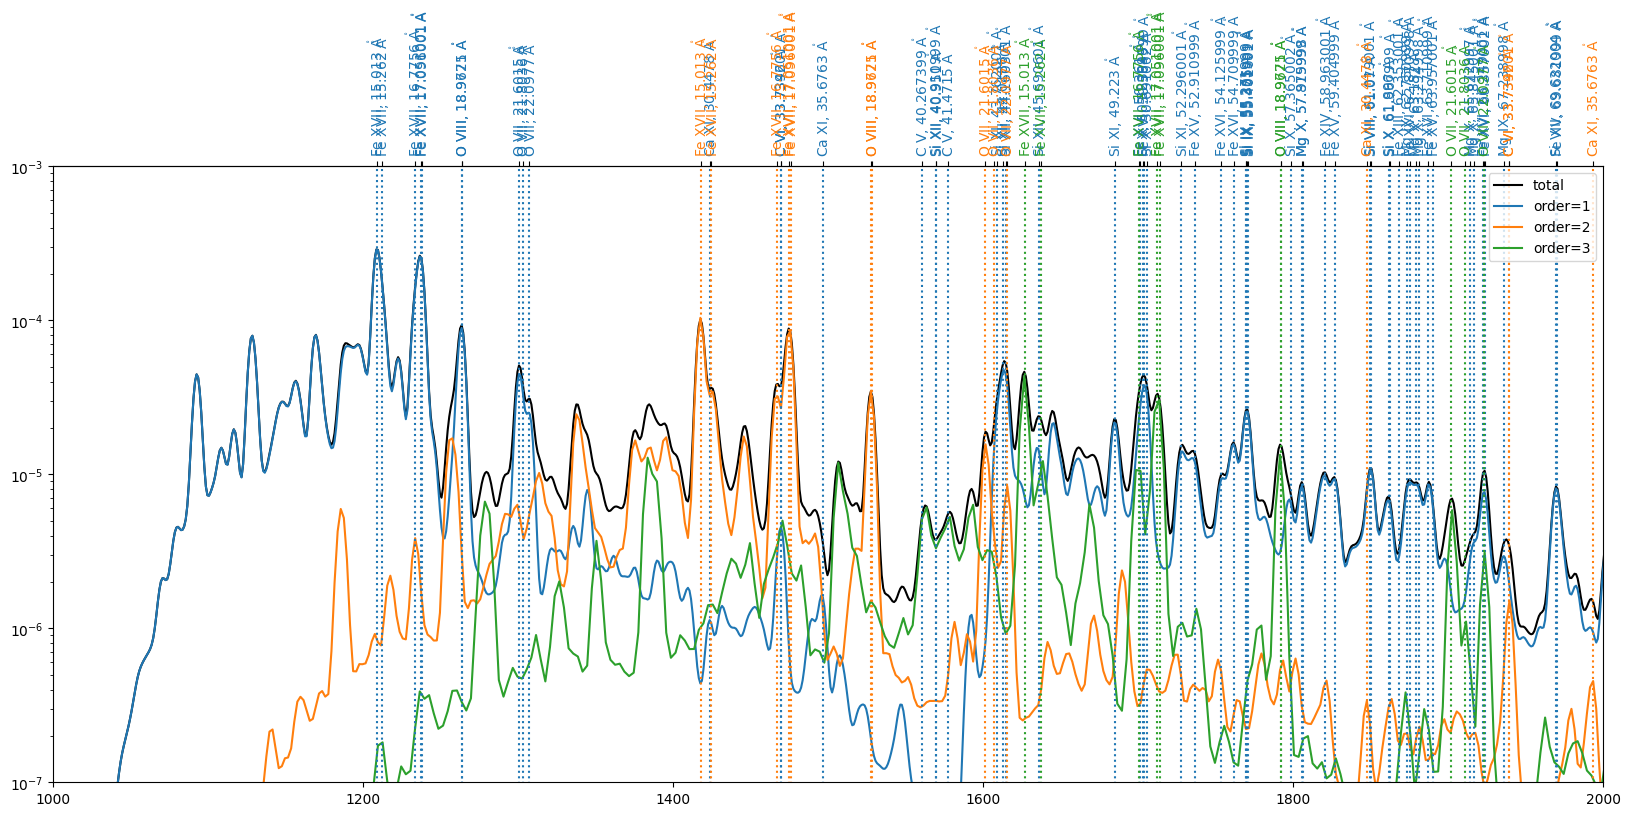

In [27]:
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot()
ax.plot(pix_grid_1, flux_tot.data, color='k', label='total')
ax.plot(pix_grid_1, flux_1.data, label='order=1')
ax.plot(pix_grid_2, flux_2.data, label='order=2')
ax.plot(pix_grid_3, flux_3.data, label='order=3')

# Add vertical lines denoting lines
tick_locations = []
for i, chan in enumerate([chan_1, chan_2, chan_3]):
    line_pos,_,_ = chan.get_wcs(flare_loc.observer).world_to_pixel(flare_loc, ar_line_labels['wavelength'])
    ax.vlines(line_pos, 0, 100, ls=':', color=f'C{i}',)
    tick_locations.append(line_pos)
# Add tick labels for lines
tick_labels = [f'{row["ion name"]}, {row["wavelength"].to_string(format="latex_inline")}' for row in ar_line_labels]
ax_top = ax.secondary_xaxis('top') 
ax_top.set_xticks(np.hstack(tick_locations),
                  labels=3*tick_labels,
                  rotation=90,
                  horizontalalignment='center',
                  color='k');
for i, tick in enumerate(ax_top.get_xticklabels()):
    if i < len(tick_labels):
        tick.set_color('C0')
    elif len(tick_labels) <= i < 2*len(tick_labels):
        tick.set_color('C1')
    else:
        tick.set_color('C2')

ax.set_yscale('log')
#ax.set_ylim(1e-3,2e0)
ax.set_ylim(1e-7, 1e-3)
#ax.set_xlim(1800,2000)
#ax.set_xlim(1500,1800)
ax.set_xlim(1000,2000)
ax.legend()

In [23]:
line_list

atomic number,ionization stage,transition,transition (latex),ion name,lower level,upper level,max temperature_flare_ext,wavelength,only theoretical_flare_ext,element,ion id,energy,abundance (coronal),abundance (photospheric),intensity (coronal)_flare_ext,intensity_scaled (coronal)_flare_ext,intensity (photospheric)_flare_ext,intensity_scaled (photospheric)_flare_ext,max temperature_active_region,only theoretical_active_region,intensity (coronal)_active_region,intensity_scaled (coronal)_active_region,intensity (photospheric)_active_region,intensity_scaled (photospheric)_active_region
,,,,,,,MK,Angstrom,,,,keV,,,ph / (cm2 s sr),,ph / (cm2 s sr),,MK,,ph / (cm2 s sr),,ph / (cm2 s sr),
int16,int16,str48,str93,str9,int16,int16,float32,float64,bool,str2,str5,float64,float64,float64,float64,float64,float64,float64,float32,bool,float64,float64,float64,float64
6,5,1s2 1S0 - 1s.2p 1P1,1s$^{2}$ $^1$S$_{0}$ - 1s 2p $^1$P$_{1}$,C V,1,7,1.0,40.267398834228516,False,C,c_5,0.3079021789900417,0.0003890451449942805,0.0002691534803926914,6533714714604.047,0.001743170922485647,4520226194711.858,0.004636371752013014,1.1220190525054932,False,329912553647.37476,0.14822303764598255,228243722308.20892,0.23036640952282866
6,5,1s2 1S0 - 1s.2p 3P1,1s$^{2}$ $^1$S$_{0}$ - 1s 2p $^3$P$_{1}$,C V,1,4,0.8912505507469177,40.730201721191406,False,C,c_5,0.3044035953514388,0.0003890451449942805,0.0002691534803926914,817185380850.2845,0.00021802203744748316,565354155454.413,0.0005798807235130193,1.0,False,47490837462.94683,0.021336672737326194,32855632191.743896,0.033161192536082684
6,5,1s2 1S0 - 1s.2s 3S1,1s$^{2}$ $^1$S$_{0}$ - 1s 2s $^3$S$_{1}$,C V,1,2,1.0,41.471500396728516,False,C,c_5,0.298962413337186,0.0003890451449942805,0.0002691534803926914,4448601168028.341,0.001186870339549656,3077680065308.1606,0.003156759927903988,1.1220190525054932,False,250709904086.47617,0.11263888912620688,173448876363.1402,0.1750619665656783
6,5,1s2 1S0 - 1s.3p 1P1,1s$^{2}$ $^1$S$_{0}$ - 1s 3p $^1$P$_{1}$,C V,1,17,1.1220190525054932,34.972801208496094,False,C,c_5,0.35451606433824995,0.0003890451449942805,0.0002691534803926914,970088269583.565,0.00025881596268700365,671137109423.0685,0.0006883817317586987,1.1220190525054932,False,44996472231.79761,0.020216004889219277,31129953072.051495,0.031419464444848534
6,6,1s 2S1/2 - 2p 2P1/2,1s $^2$S$_{1/2}$ - 2p $^2$P$_{1/2}$,C VI,1,3,11.220189094543457,33.739601135253906,False,C,c_6,0.3674738119640999,0.0003890451449942805,0.0002691534803926914,157924415453753.56,0.04213364999763524,109257001675175.8,0.11206432033623354,1.5848925113677979,False,523641758655.5146,0.23526165115003184,362271586304.34393,0.3656407447490605
6,6,1s 2S1/2 - 2p 2P3/2,1s $^2$S$_{1/2}$ - 2p $^2$P$_{3/2}$,C VI,1,4,11.220189094543457,33.73419952392578,False,C,c_6,0.3675326528654258,0.0003890451449942805,0.0002691534803926914,289421291045608.6,0.07721653009600904,200230612788695.44,0.20537546508354335,1.5848925113677979,False,855361668545.9404,0.384296697400997,591765693636.9792,0.5972691679898798
6,6,1s 2S1/2 - 3p 2P1/2,1s $^2$S$_{1/2}$ - 3p $^2$P$_{1/2}$,C VI,1,6,11.220189094543457,28.466299057006836,False,C,c_6,0.4355473052008219,0.0003890451449942805,0.0002691534803926914,20029673823547.336,0.00534384290119645,13857148688534.355,0.014213203051238077,1.5848925113677979,False,44602733254.508934,0.020039105930364474,30857552253.10524,0.031144530273704105
6,6,1s 2S1/2 - 3p 2P3/2,1s $^2$S$_{1/2}$ - 3p $^2$P$_{3/2}$,C VI,1,7,11.220189094543457,28.465200424194336,False,C,c_6,0.4355641154306379,0.0003890451449942805,0.0002691534803926914,40066139099582.625,0.010689497736800134,27718995914237.4,0.028431225366837343,1.5848925113677979,False,89273505126.47072,0.04010878023542279,61762175728.982864,0.062336569536800175
